In [ ]:
import kagglehub
from pathlib import Path

# Download latest version
path = Path(kagglehub.dataset_download("christianlillelund/csgo-round-winner-classification"))

print("Path to dataset files:", path)

import pandas as pd
df = pd.read_csv(path/'csgo_round_snapshots.csv')

/home/annekin/workspace/ibm-ml-certificate/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/annekin/.cache/kagglehub/datasets/christianlillelund/csgo-round-winner-classification/versions/3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  float64
 2   t_score                       122410 non-null  float64
 3   map                           122410 non-null  object 
 4   bomb_planted                  122410 non-null  bool   
 5   ct_health                     122410 non-null  float64
 6   t_health                      122410 non-null  float64
 7   ct_armor                      122410 non-null  float64
 8   t_armor                       122410 non-null  float64
 9   ct_money                      122410 non-null  float64
 10  t_money                       122410 non-null  float64
 11  ct_helmets                    122410 non-null  float64
 12  t_helmets                     122410 non-nul

In [4]:
df.dtypes.value_counts()

float64    94
object      2
bool        1
Name: count, dtype: int64

In [5]:
df.shape

(122410, 97)

In [6]:
df.dtypes[df.dtypes != 'float64']

map             object
bomb_planted      bool
round_winner    object
dtype: object

In [7]:
df.isnull().sum().sort_values(ascending=False)

time_left                    0
ct_score                     0
t_score                      0
map                          0
bomb_planted                 0
                            ..
ct_grenade_molotovgrenade    0
t_grenade_molotovgrenade     0
ct_grenade_decoygrenade      0
t_grenade_decoygrenade       0
round_winner                 0
Length: 97, dtype: int64

# Data Cleaning and Feature Engineering
We onehot encode the map feature, and make sure the make all features float and the predict label a int (T_round_winner).

The dataset is balanced (T:62406-CT:60004)

We can see there aren't any indviaul fields that have high correlation with round winner (best is ~0.4) (barplot is filtered to show >0.2).

We alos scale all the features with StandardScaler

In [8]:
data = df.copy()

In [9]:
map_ohe = pd.get_dummies(data['map'], dtype='float64')
data = data.drop(['map'], axis=1)
data = pd.concat([data, map_ohe], axis=1)

In [10]:
data["bomb_planted"] = data["bomb_planted"].astype("float64")

In [11]:
T_winner = pd.get_dummies(data['round_winner'], drop_first=True, dtype="int")
T_winner = T_winner.rename(columns={'T':'T_round_winner'})
data = data.drop(['round_winner'], axis=1)
data = pd.concat([data, T_winner], axis=1)
data.head().T

,0,1,2,3,4
time_left,175.0,156.03,96.03,76.03,174.97
ct_score,0.0,0.00,0.00,0.00,1.00
t_score,0.0,0.00,0.00,0.00,0.00
bomb_planted,0.0,0.00,0.00,0.00,0.00
ct_health,500.0,500.00,391.00,391.00,500.00
...,...,...,...,...,...
de_nuke,0.0,0.00,0.00,0.00,0.00
de_overpass,0.0,0.00,0.00,0.00,0.00
de_train,0.0,0.00,0.00,0.00,0.00
de_vertigo,0.0,0.00,0.00,0.00,0.00


In [12]:
data.dtypes.value_counts()

float64    103
int64        1
Name: count, dtype: int64

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [14]:
corr = data.corr()


<Axes: >

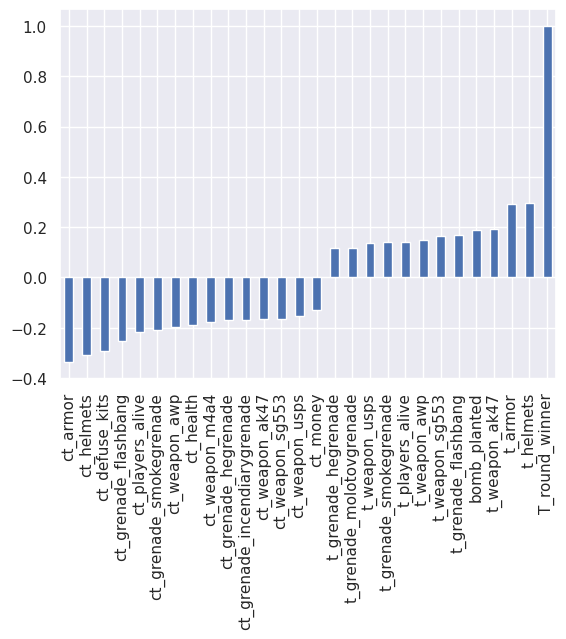

In [15]:
import numpy as np


corr_T_round_winner = corr['T_round_winner']
corr_T_round_winner = corr_T_round_winner[corr_T_round_winner.abs() > 0.1]
corr_T_round_winner.sort_values().plot.bar()

In [16]:
data['T_round_winner'].value_counts()

T_round_winner
1    62406
0    60004
Name: count, dtype: int64

In [17]:


from sklearn.discriminant_analysis import StandardScaler


float_64_columns = data.select_dtypes('float64').columns
data[float_64_columns] = StandardScaler().fit_transform(data[float_64_columns])

In [18]:
from sklearn.model_selection import train_test_split

X = data.iloc[:, 0:-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

def evaluate_metrics(y_test, y_pred, name=''):
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': float(roc_auc_score(y_test, y_pred)),
        'name': name
    }

# Model Training

Since the prdicator class is possitu=ive depending on the team your in, we'll be optimizing for accuracy over any other metric. Since True positive and True negative are equally as important.

The following are base line models, with default parameters

In [20]:
baseline_results = []

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Baseline Model
lr = LogisticRegression().fit(X_train, y_train)
lr_pred = lr.predict(X_test)
baseline_results.append(evaluate_metrics(y_test, lr_pred, name='Linear Regression'))
baseline_results[-1]

{'accuracy': 0.7546360591454947,
 'recall': 0.7484216414928474,
 'precision': 0.7661158376963351,
 'f1': 0.7571653797954481,
 'auc': 0.7547772841101131,
 'name': 'Linear Regression'}

In [22]:
knn = KNeighborsClassifier().fit(X_train, y_train)
knn_pred = knn.predict(X_test)
baseline_results.append(evaluate_metrics(y_test, knn_pred, name='KNN'))
baseline_results[-1]

{'accuracy': 0.8429458377583531,
 'recall': 0.8440022376728202,
 'precision': 0.8480006423638992,
 'f1': 0.8459967156646774,
 'auc': 0.8429218306753273,
 'name': 'KNN'}

In [23]:
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier().fit(X_train, y_train)
dt_pred = dt.predict(X_test)
baseline_results.append(evaluate_metrics(y_test, dt_pred, name='Decision Tree'))
baseline_results[-1]

{'accuracy': 0.8285679274569071,
 'recall': 0.8292975305682091,
 'precision': 0.8342981186685963,
 'f1': 0.8317903090056511,
 'auc': 0.8285513469534169,
 'name': 'Decision Tree'}

In [24]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier().fit(X_train, y_train)
rf_pred = rf.predict(X_test)
baseline_results.append(evaluate_metrics(y_test, rf_pred, name='Random Forest'))
baseline_results[-1]

{'accuracy': 0.8811371619965689,
 'recall': 0.8743706545193,
 'precision': 0.8910334717810897,
 'f1': 0.8826234269119071,
 'auc': 0.8812909334088688,
 'name': 'Random Forest'}

In [25]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier([
    ('lr', lr),
    ('knn', knn),
    ('dt', dt),
    ('rf', rf),
]).fit(X_train, y_train)
vc_pred = vc.predict(X_test)
baseline_results.append(evaluate_metrics(y_test, vc_pred, name='Voting'))
baseline_results[-1]

{'accuracy': 0.8650437055796095,
 'recall': 0.8156317429872932,
 'precision': 0.9110059805409265,
 'f1': 0.8606847697756789,
 'auc': 0.8661666109037895,
 'name': 'Voting'}

In [26]:

from sklearn.ensemble import StackingClassifier

sc = StackingClassifier([
    ('lr', lr),
    ('knn', knn),
    ('dt', dt),
    ('rf', rf),
    ], LogisticRegression()
).fit(X_train, y_train)
sc_pred = sc.predict(X_test)
baseline_results.append(evaluate_metrics(y_test, sc_pred, name='Stacking'))
baseline_results[-1]

{'accuracy': 0.8955150722980149,
 'recall': 0.896667465835531,
 'precision': 0.8986784140969163,
 'f1': 0.8976718137450996,
 'auc': 0.8954888837240149,
 'name': 'Stacking'}

In [27]:
def visualize_eval_metrics(results):
    df = pd.DataFrame(results).set_index('name')
    #table = pd.pivot_table(df, values='type', index=['accuracy', 'precision', 'recall', 'f1', 'auc'],
    #                columns=['type'])
    #df = df.set_index('type').transpose()
    print(df)
    x = np.arange(5)
    width = 0.1
    plt.figure(figsize=(12, 10), dpi=80)
    for i, r_i in enumerate(range(df.shape[0])):
        plt.bar(x-0.1+i*width, df.iloc[r_i, :], width)
    plt.xticks(x, df.columns.tolist())
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.ylim(df.min().min()-0.1, 1)
    plt.legend(df.index.tolist())
    plt.show()

                   accuracy    recall  precision        f1       auc
name                                                                
Linear Regression  0.754636  0.748422   0.766116  0.757165  0.754777
KNN                0.842946  0.844002   0.848001  0.845997  0.842922
Decision Tree      0.828568  0.829298   0.834298  0.831790  0.828551
Random Forest      0.881137  0.874371   0.891033  0.882623  0.881291
Voting             0.865044  0.815632   0.911006  0.860685  0.866167
Stacking           0.895515  0.896667   0.898678  0.897672  0.895489


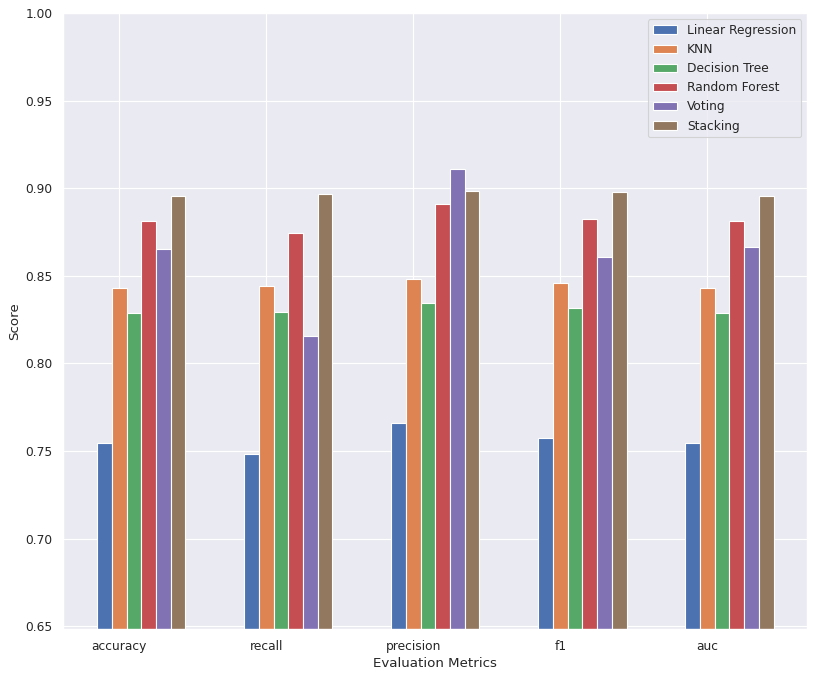

In [28]:
visualize_eval_metrics(baseline_results)

In [29]:
optimized_results = []

In [30]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# rf_cv = GridSearchCV(
#     RandomForestClassifier(n_jobs=-1),
#     {
#         'n_estimators': [50, 100, 200, 400],
#     },
#     scoring='accuracy',
#     n_jobs=-1
# ).fit(X_train, y_train)
# rf_cv_pred = rf_cv.predict(X_test)

# print(rf_cv.best_params_)
# optimized_results.append(evaluate_metrics(y_test, rf_cv_pred, name='Random Forest CV'))
# optimized_results[-1]


In [31]:
# from sklearn.neighbors import KNeighborsClassifier

# knn_cv = GridSearchCV(
#     KNeighborsClassifier(n_jobs=-1),
#     {
#         'n_neighbors': np.linspace(5, 200, 20, dtype='int'),
#     },
#     scoring='accuracy',
#     n_jobs=-1
# ).fit(X_train, y_train)
# knn_cv_pred = knn_cv.predict(X_test)

# print(knn_cv.best_params_)
# optimized_results.append(evaluate_metrics(y_test, knn_cv_pred, name='KNN CV'))
# optimized_results[-1]

In [32]:
visualize_eval_metrics(optimized_results)

KeyError: "None of ['name'] are in the columns"

In [33]:
from sklearn.inspection import permutation_importance


feature_importances = permutation_importance(
    estimator=sc, 
    X = X_train, 
    y = y_train, 
    n_repeats=5,
    n_jobs=-1
)

feature_importances.importances.shape

KeyboardInterrupt: 

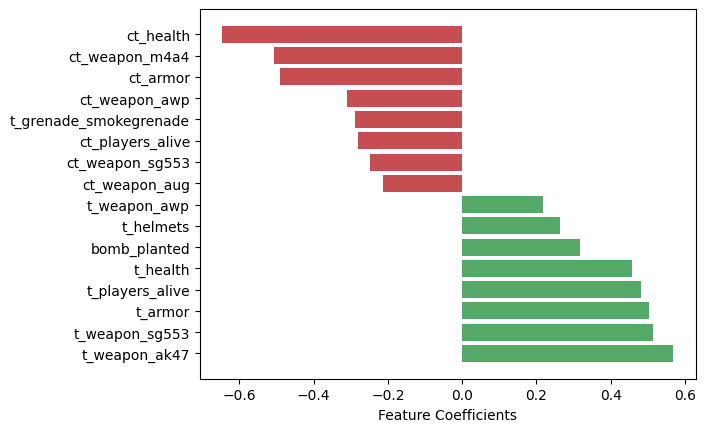

In [38]:
def get_feature_coefs(regression_model):
    coef_dict = {}
    # Filter coefficients less than 0.01
    for coef, feat in zip(regression_model.coef_[0, :], X_test.columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals
def visualize_coefs(_coef_dict, tol=0.2):
    coef_dict = {}

    for key,value in _coef_dict.items():
        if abs(value) > tol:
            coef_dict[key] = value

    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    plt.show()

visualize_coefs(get_feature_coefs(lr))